In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import scipy
import pandas as pd
import torch
from torch import nn


In [3]:
import criscas
from criscas.utilities import create_directory, get_device, report_available_cuda_devices
from criscas.predict_model import *


In [4]:
base_dir = os.path.abspath('..')
base_dir

'/mnt/orisenbazuru/crispr'

### Read sample data

In [5]:
seq_df = pd.read_csv(os.path.join(base_dir, 'sample_data', 'abemax_sampledata.csv'), header=0)

In [6]:
seq_df

,ID,seq
0,CTRL_HEKsiteNO18,ACACACACACTTAGAATCTG
1,CTRL_RSF1NO2,ACCCATTAAAGTTGAGGTGA
2,CTRL_EMX1NO2,AGATTTATGCAAACGGGTTG
3,CTRL_FANCFNO3,AGCGGCGGCTGCACAACCAG
4,CTRL_FANCFNO5,AGGCCCGGCGCACGGTGGCG
5,CTRL_TARDBPNO2,CGGGAGTTCTTCTCTCAGTA
6,CTRL_HEKsiteNO1,GAACACAAAGCATAGACTGC
7,CTRL_HEKsiteNO9,GAAGACCAAGGATAGACTGC
8,CTRL_HEKsiteNO2,GAGTATGAGGCATAGACTGC
9,CTRL_EMX1NO1,GAGTCCGAGCAGAAGAAGAA


The models expect sequences (i.e. target sites) to be wrapped in a `pandas.DataFrame` with a header that includes `ID` of the sequence and `seq` columns.
The sequences should be of length 20 (i.e. 20 bases) and represent the protospacer target site.

In [7]:
# create a directory where we dump the predictions of the models
csv_dir = create_directory(os.path.join(base_dir, 'sample_data', 'predictions'))

### Specify device (i.e. CPU or GPU) to run the models on

Specify device to run the model on. The models can run on `GPU` or `CPU`. We can instantiate a device by running `get_device(to_gpu,gpu_index)` function. 

- To run on GPU we pass `to_gpu = True` and specify which card to use if we have multiple cards `gpu_index=int` (i.e. in case we have multiple GPU cards we specify the index counting from 0). 
- If there is no GPU installed, the function will return a `CPU` device.

We can get a detailed information on the GPU cards installed on the compute node by calling `report_available_cuda_devices` function.

In [ ]:
report_available_cuda_devices()

In [9]:
# instantiate a device using the only one available :P
device = get_device(True, 0)
device

device(type='cuda', index=0)

### Create a BE-DICT model by sepcifying the target base editor 

We start `BE-DICT` model by calling `BEDICT_CriscasModel(base_editor, device)` where we specify which base editor to use (i.e. `ABEmax`, `BE4max`, `ABE8e`, `Target-AID`) and the `device` we create earlier to run on.

In [10]:
base_editor = 'ABEmax'
bedict = BEDICT_CriscasModel(base_editor, device)

We generate predictions by calling `predict_from_dataframe(seq_df)` where we pass the data frame wrapping the target sequences. The function returns two objects:

- `pred_w_attn_runs_df` which is a data frame that contains predictions per target base and the attentions scores across all positions.

- `proc_df` which is a data frame that represents the processed sequence data frame we passed (i.e. `seq_df`)

In [11]:
pred_w_attn_runs_df, proc_df = bedict.predict_from_dataframe(seq_df)

--- processing input data frame ---
--- creating datatensor ---
--- building model ---
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_0
running prediction for base_editor: ABEmax | run_num: 0
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_1
running prediction for base_editor: ABEmax | run_num: 1
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_2
running prediction for base_editor: ABEmax | run_num: 2
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_3
running prediction for base_editor: ABEmax | run_num: 3
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_4
running prediction for base_editor: ABEmax | run_num: 4


`pred_w_attn_runs_df` contains predictions from 5 trained models for `ABEmax` base editor (we have 5 runs trained per base editor). For more info, see our [paper](https://www.biorxiv.org/content/10.1101/2020.07.05.186544v1) on biorxiv.

Target positions in the sequence reported in `base_pos` column in `pred_w_attn_runs_df` uses 0-based indexing (i.e. 0-19)

In [12]:
pred_w_attn_runs_df

,id,base_pos,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,Attn5,...,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19,run_id,model_name
0,CTRL_HEKsiteNO18,0,0.999415,0.000585,0.045729,0.042664,0.066255,0.050064,0.116043,0.051546,...,0.035064,0.034923,0.039356,0.037878,0.044793,0.036754,0.042779,0.036226,run_0,ABEmax
1,CTRL_HEKsiteNO18,2,0.977170,0.022830,0.048284,0.045546,0.065379,0.052430,0.118339,0.056224,...,0.034674,0.035190,0.037261,0.035668,0.044894,0.037269,0.043467,0.036456,run_0,ABEmax
2,CTRL_HEKsiteNO18,4,0.078551,0.921449,0.054976,0.052280,0.066336,0.051879,0.119195,0.064469,...,0.034636,0.035900,0.033345,0.033022,0.045787,0.038039,0.045020,0.037313,run_0,ABEmax
3,CTRL_HEKsiteNO18,6,0.244241,0.755759,0.051713,0.049951,0.065074,0.053286,0.117797,0.061450,...,0.035030,0.035886,0.034538,0.033984,0.045972,0.038010,0.044987,0.037315,run_0,ABEmax
4,CTRL_HEKsiteNO18,8,0.943315,0.056685,0.047474,0.046356,0.064007,0.054446,0.120607,0.058995,...,0.034409,0.035045,0.036596,0.034991,0.044300,0.037305,0.042665,0.036274,run_0,ABEmax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,CTRL_NEK1NO2,11,0.758516,0.241484,0.036393,0.045026,0.063008,0.041671,0.070086,0.063250,...,0.039837,0.050302,0.038627,0.049057,0.042429,0.038799,0.048865,0.066496,run_4,ABEmax
601,CTRL_NEK1NO2,13,0.983103,0.016897,0.036448,0.043342,0.063902,0.040840,0.076771,0.062669,...,0.039236,0.048777,0.038183,0.047606,0.042249,0.038294,0.046798,0.066615,run_4,ABEmax
602,CTRL_NEK1NO2,15,0.999396,0.000604,0.036391,0.041151,0.065346,0.039581,0.085820,0.062010,...,0.038485,0.046463,0.037472,0.045400,0.042080,0.037553,0.043789,0.066748,run_4,ABEmax
603,CTRL_NEK1NO2,18,0.997911,0.002089,0.036392,0.041694,0.064977,0.039885,0.084049,0.062504,...,0.038635,0.046852,0.037606,0.045773,0.042083,0.037721,0.044341,0.066446,run_4,ABEmax


In [13]:
proc_df

,index,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20
0,0,1,0,1,0,1,0,1,0,1,...,2,2,0,3,0,0,2,1,2,3
1,1,1,0,0,0,1,0,0,1,1,...,3,2,2,3,0,3,3,2,3,0
2,2,1,0,1,0,0,0,1,0,0,...,0,0,0,1,3,3,3,2,2,3
3,3,1,0,0,0,0,0,0,0,0,...,3,1,0,1,0,0,1,1,0,3
4,4,1,0,0,0,0,0,0,0,0,...,1,0,1,3,3,2,3,3,1,3
5,5,0,0,0,0,1,0,0,0,0,...,2,1,2,1,2,1,0,3,2,0
6,6,0,1,1,0,1,0,1,1,1,...,1,0,2,0,3,0,1,2,3,1
7,7,0,1,1,0,1,0,0,1,1,...,3,0,2,0,3,0,1,2,3,1
8,8,0,1,0,0,1,0,0,1,0,...,1,0,2,0,3,0,1,2,3,1
9,9,0,1,0,0,0,0,0,1,0,...,0,3,0,0,3,0,0,3,0,0


Given that we have 5 predictions per sequence, we can further reduce to one prediction by either `averaging` across all models, or taking the `median` or `max` prediction based on the probability of editing scores. For this we use `select_prediction(pred_w_attn_runs_df, pred_option)` where `pred_w_attn_runs_df` is the data frame containing predictions from 5 models for each sequence. `pred_option` can be assume one of {`mean`, `median`, `max`}.

In [14]:
pred_option = 'mean'
pred_w_attn_df = bedict.select_prediction(pred_w_attn_runs_df, pred_option)

In [15]:
pred_w_attn_df

,id,base_pos,model_name,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,...,Attn10,Attn11,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19
0,CTRL_DOCK3NO2,1,ABEmax,0.995987,0.004013,0.042520,0.052131,0.057854,0.054529,0.109479,...,0.039865,0.041499,0.037517,0.035766,0.040089,0.038940,0.043273,0.035928,0.036010,0.042516
1,CTRL_DOCK3NO2,2,ABEmax,0.985492,0.014508,0.042437,0.053213,0.057332,0.054501,0.108636,...,0.040659,0.042084,0.037899,0.036223,0.040019,0.038964,0.043569,0.036404,0.036753,0.042718
2,CTRL_DOCK3NO2,4,ABEmax,0.049553,0.950447,0.040683,0.054747,0.056928,0.059296,0.104593,...,0.042162,0.046675,0.040153,0.038083,0.040977,0.040358,0.041609,0.038905,0.039585,0.040185
3,CTRL_DOCK3NO2,8,ABEmax,0.924553,0.075447,0.041839,0.053119,0.057267,0.056283,0.107681,...,0.040620,0.043281,0.038436,0.036585,0.040445,0.039410,0.042494,0.036970,0.037269,0.041577
4,CTRL_DOCK3NO2,9,ABEmax,0.973775,0.026225,0.042013,0.053485,0.057264,0.054337,0.109077,...,0.040495,0.042716,0.038180,0.036429,0.040307,0.039253,0.043071,0.036662,0.036957,0.042320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,HEKsite7LV,9,ABEmax,0.583722,0.416278,0.039260,0.056255,0.056398,0.083464,0.067149,...,0.040832,0.046035,0.040630,0.039747,0.043635,0.041369,0.038700,0.037778,0.038607,0.038633
117,HEKsite7LV,11,ABEmax,0.942926,0.057074,0.038321,0.055229,0.059637,0.087058,0.065302,...,0.040233,0.043471,0.039681,0.039247,0.043512,0.042397,0.037361,0.036608,0.037229,0.037263
118,HEKsite7LV,12,ABEmax,0.986732,0.013268,0.037408,0.055749,0.061097,0.086182,0.065870,...,0.040302,0.042878,0.038913,0.038729,0.042908,0.043509,0.036384,0.035734,0.036247,0.036423
119,HEKsite7LV,13,ABEmax,0.995614,0.004386,0.037671,0.054393,0.061604,0.089015,0.065010,...,0.039709,0.041896,0.038756,0.038669,0.043320,0.043302,0.036381,0.035786,0.036253,0.036380


We can dump the prediction results on a specified directory on disk. We will dump the predictions with all 5 runs `pred_w_attn_runs_df` and the one average across runs `pred_w_attn_df`.

Under `sample_data` directory we will have the following tree:

<pre>
sample_data
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</pre>

In [16]:
pred_w_attn_runs_df.to_csv(os.path.join(csv_dir, f'predictions_allruns.csv'))

In [17]:
pred_w_attn_df.to_csv(os.path.join(csv_dir, f'predictions_predoption_{pred_option}.csv'))

### Generate attention plots

We can generate attention plots for the prediction of each target base in the sequence using `highlight_attn_per_seq` method that takes the following arguments:

- `pred_w_attn_runs_df`: data frame that contains model's predictions (5 runs) for each target base of each sequence (see above).
- `proc_df`: data frame that represents the processed sequence data frame we passed (i.e. seq_df)
- `seqid_pos_map`: dictionary `{seq_id:list of positions}` where `seq_id` is the ID of the target sequence, and list of positions that we want to generate attention plots for. Users can specify a `position from 1 to 20` (i.e. length of protospacer sequence)
- `pred_option`: selection option for aggregating across 5 models' predictions. That is we can average the predictions across 5 runs, or take `max`, `median`, `min` or `None` (i.e. keep all 5 runs) 
- `apply_attnscore_filter`: boolean (`True` or `False`) to further apply filtering on the generated attention scores. This filtering allow to plot only predictions where the associated attention scores have a maximum that is >= 3 times the base attention score value <=> (3 * 1/20)
- `fig_dir`: directory where to dump the generated plots or `None` (to return the plots inline)

seq_id: CTRL_HEKsiteNO1
highlighting seqid:CTRL_HEKsiteNO1, pos:4
seq_id: CTRL_HEKsiteNO2
highlighting seqid:CTRL_HEKsiteNO2, pos:4


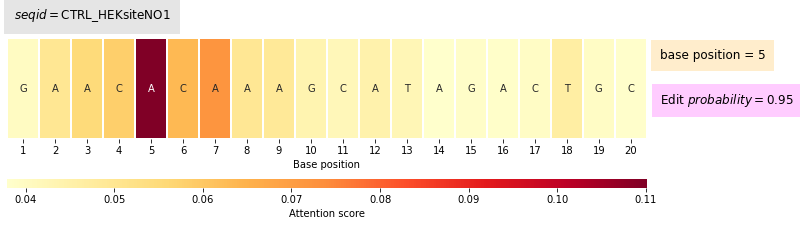

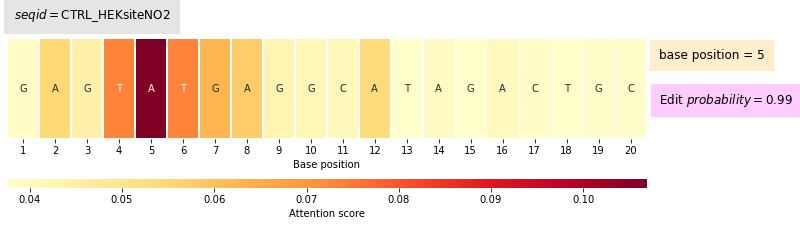

In [18]:
# create a dictionary to specify target sequence and the position we want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=None)

We can save the plots on disk without returning them by specifing `fig_dir`

In [19]:
# create a dictionary to specify target sequence and the position I want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
fig_dir =  create_directory(os.path.join(base_dir, 'sample_data', 'fig_dir'))
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=create_directory(os.path.join(fig_dir, pred_option)))

seq_id: CTRL_HEKsiteNO1
highlighting seqid:CTRL_HEKsiteNO1, pos:4
seq_id: CTRL_HEKsiteNO2
highlighting seqid:CTRL_HEKsiteNO2, pos:4


We will generate the following files:

<pre>
sample_data
├── abemax_sampledata.csv
├── fig_dir
│   └── mean
│       ├── ABEmax_seqattn_CTRL_HEKsiteNO1_basepos_5_predoption_mean.pdf
│       └── ABEmax_seqattn_CTRL_HEKsiteNO2_basepos_5_predoption_mean.pdf
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</pre>

Similarly we can change the other arguments such as `pred_option` `apply_attnscore_filter` and so on to get different filtering options - We leave this as an exercise for the user/reader :D